# VGGNet (2014)
* El grupo se llama Visual Geometry Group (VGG) Del departamento de ciencia e ingeniería de la Universidad de Oxford.

* Obtuvieron el segundo lugar en el concurso ILSVRC: Imaging Large Scale Vision Recognition Challenge. Una precision de 92.7 \% En el año 2014.

* Más de 14 millones de imágenes y 1000 clases.

* Las convoluciones todas son kernels de tamaño $3 \times 3$. Padding SAME
(las dimensiones de entrada se conservan a la salida). Pooling con kernels
$2 \times 2$ y striding $s=2$.

* El entrenamiento se hizo con tarjetas gráficas NVIDIA Titan Black GPUś.

* Activación es ReLU

## Arquitectura.
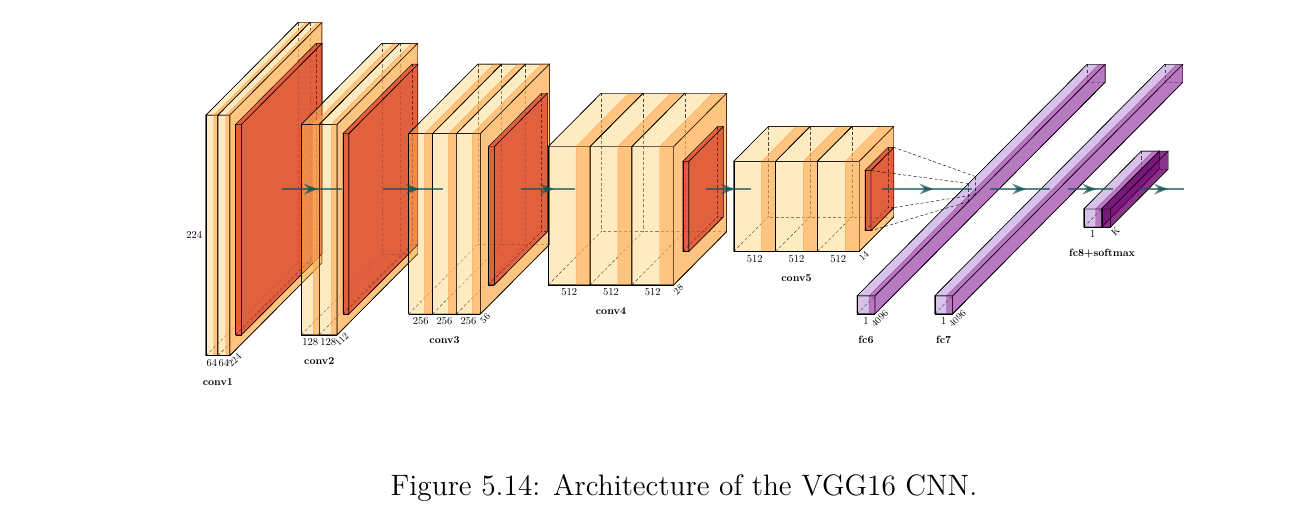

La VGG16 es la más popular, pero hay desde 16 hasta 19.

La arquitectura es, no en tanto detalle

* **Capa de entrada y primera capa convolutiva**: La entrada es de $$224 \times 224 \ \times 3 $$
La convolución lleva 64 filtros. Seguida por un MaxPooling layer.

* **Segunda capa convolutiva**: Tenemos acá dos convoluciones con 128 filtros, seguidas de MaxPooling.

* **Tercera capa convolutiva**: Tres convoluciones con 256 filtros cada una seguidas de MaxPooling.

* **Cuarta capa convolutiva**: Tres convoluciones cada una con 512 filtros y termina con un MaxPooling.

* **Quinta capa convolutiva**: Tres convoluciones cada una con 512 filtros y termina con un MaxPooling.

* **Flattening**: Se vectoriza la matriz en una "tira" de 4096 componentes.

* **Fully Connected**: Se conectan tipo MLP, 4096 nodos con 4096 nodos.

* **Fully Connected**: Los 4096 de entrada con 1000 de salida (el SoftMax).


* Es una red grande. En total hay mas de 134 Millones de parámetros.
* El MaxPooling reduce tamaños de 224/128/56/28/14 mientras que los filtros se duplican 64, 128, 256, 512. Se repite este ultimo 512.

Hacemos una implementación en `Python`.

In [1]:
# implementación de la VGG16
import tensorflow as tf
tf.__version__

'2.19.0'

In [2]:
import keras
keras.__version__

'3.10.0'

In [3]:
# import libraries
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.layers import MaxPooling2D, Input
from keras.utils import to_categorical
import numpy as np
import os
import urllib.request
import tarfile

# function to download and extract the oxflower17 dataset
def download_and_extract_data(dest_dir="."):
    url="http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"
    filename = url.split('/')[-1]
    filepath = os.path.join(dest_dir, filename)

    # control de calida (assert)
    if not os.path.exists(filepath):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
        print("Download complete.")

    print(f"Extracting {filename}...")
    with tarfile.open(filepath, "r:gz") as tar:
        tar.extractall(path=dest_dir)
    print("Extraction complete.")

    return os.path.join(dest_dir, "jpg")

# download and extract the dataset
image_dir = download_and_extract_data()

# Dummy data (replace with actual daa loading and preprocessing)
X = np.random.rand(1360, 224, 224, 3)
Y = np.random.randint(0, 17, size=(1360,))

# convert to one-hot-encoding
Y = to_categorical(Y, num_classes=17)



Extracting 17flowers.tgz...


/tmp/ipython-input-3248064372.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=dest_dir)


Extraction complete.


In [4]:
# Veamos los tamaños de los datos
print(f"Tamaño de X: {X.shape}")
print(f"Tamaño de Y: {Y.shape}")

Tamaño de X: (1360, 224, 224, 3)
Tamaño de Y: (1360, 17)


In [5]:
# construimos un vgg_block()
def vgg_block(x, n_filters, n_convs):
    for _ in range(n_convs):
        x = Conv2D(n_filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x


# arquitectura
# bloques convolutivos
inp = Input(shape=(224, 224, 3))
x = vgg_block(inp, 64, 2)
x = vgg_block(x, 128, 2)
x = vgg_block(x, 256, 3)
x = vgg_block(x, 512, 3)
x = vgg_block(x, 512, 3)

# flatten and dense layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
out = Dense(17, activation='softmax')(x)

model = Model(inp, out)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4096)           │        16,38

 Total params: 134,346,577 (512.49 MB)

 Trainable params: 134,338,385 (512.46 MB)

 Non-trainable params: 8,192 (32.00 KB)

In [6]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
model.fit(X, Y, batch_size=32, epochs=10, validation_split=0.2, shuffle=True)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.0589 - loss: 3.5215 - val_accuracy: 0.0221 - val_loss: 8.6278
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 544ms/step - accuracy: 0.0628 - loss: 3.4437 - val_accuracy: 0.0735 - val_loss: 4.2686
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 560ms/step - accuracy: 0.0464 - loss: 3.3992 - val_accuracy: 0.0735 - val_loss: 3.0788
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step - accuracy: 0.0423 - loss: 3.3479 - val_accuracy: 0.0515 - val_loss: 2.8669
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 545ms/step - accuracy: 0.0636 - loss: 3.3013 - val_accuracy: 0.0588 - val_loss: 3.4210
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 553ms/step - accuracy: 0.0697 - loss: 3.2416 - val_accuracy: 0.0515 - val_loss: 3.4370
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 552ms/step - accuracy: 0.0606 - loss: 3.2758 - val_accuracy: 0.0588 - val_loss: 10.3853
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 550ms/step - accuracy: 0.0543 - loss: 3.3073 - val_accura

Por que esta precisión es tan mala si es misma arquitectura que se hizo en
las notas de clase. Peor aun en la validación es mejor la precisión que en el entrenamiento.


# GoogLeNet (2014) : The Inception family
* La idea original fue publicada en 2015 por Szegey et al.
C. Szegedy, Wei Liu, Yangqing Jia, P. Sermanet, S. Reed, D. Anguelov, D. Erhan,
V. Vanhoucke, and A. Rabinovich. Going deeper with convolutions. In 2015 IEEE
Conference on Computer Vision and Pattern Recognition (CVPR), pages 1–9, June
2015.

* Hasta el momento las redes eran pilas , secuencias lineales, una tras otra de capas canvolutivas. Ahora esta gente de Google se les ocurrio hacer una red que sea como "en paralelo". No es secuencial. Los detalles los mostramos en unos minutos. La topología de red es muy distinta a las anteriores.

* La GoogLeNet introduce convoluciones con kernels de $1 \times 1$. Estas convoluciones son intesantes y vamos a verlas con detalle en unos minutos.
De acuerdo a Brownlee, este tipo de convoluciones se introdujo en 2013 por Min Lin, et. al. En el articulo "Network in Network".
[49] Min Lin, Qiang Chen, and Shuicheng Yan. Network in network. https://arxiv.org/
abs/1312.4400, 2014.

* La Figura 5.15, extraida del articulo original muestra la arquitectura.






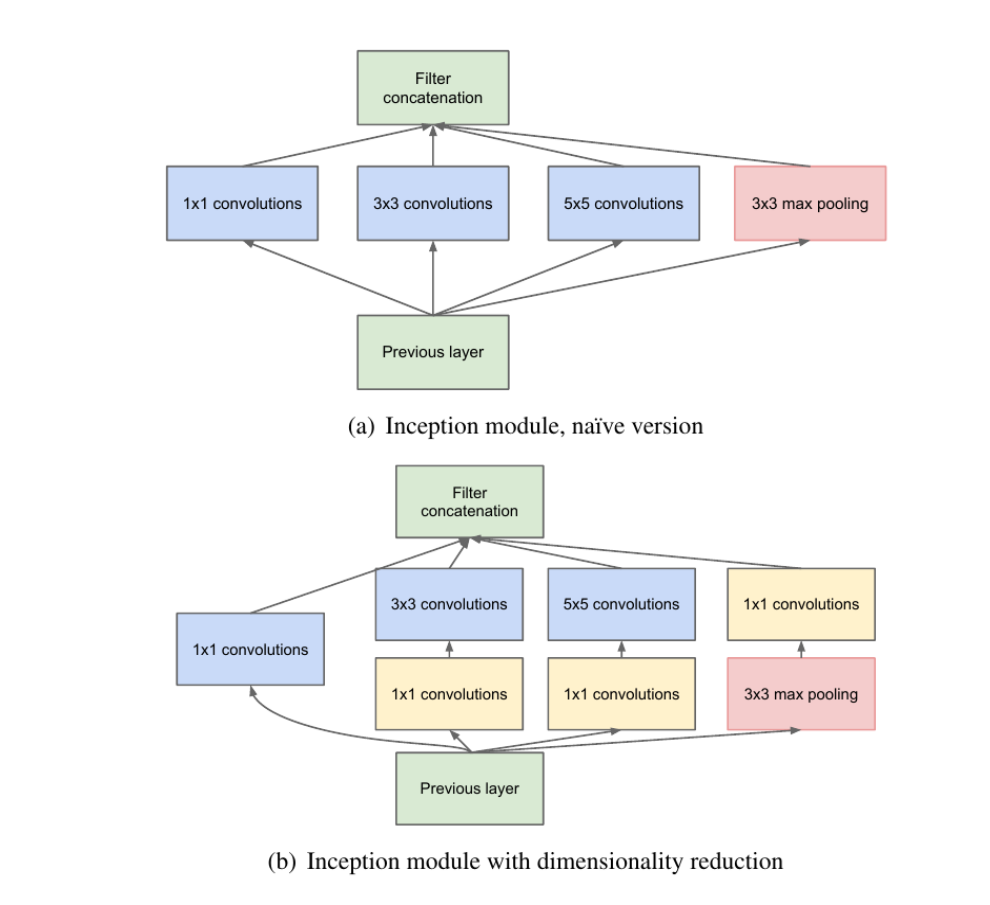

Paramos hasta las 8:00 y seguimos a las 8:00.

## Que es una convolucion $1 \times 1$?
Las convoluciones $1 \times 1$ tienen un kernel de un solo numero. Un escalar. Esto en $x-y$, pero en profundidad, la convolucion se usan el mismo numero de componentes que la profundidad de los datos de entrada. Es decir, que se usa una $n_d \times n_d$.

Este tipo de filtros lo que hace es no hay suma a lo largo de $i,j$ pero si
a lo largo de $k$ (de la profundidad). Si el filtro es

$$f_{ijk} $$
como no hay suma a lo largo de $i,j$

$$\text{out}_{ij} = \sum_{\ell=1}^k f_{ij \ell} \text{in}_{i j \ell} \tag{1} $$
con $i=1,2, \cdots, \text{width}$, $j=1,2 \cdots, \text{hegiht}$

La convolución $1 \times 1$ hace como un AveragePooling a lo largo de la profundidad (del tercer indice).

Además de esto la convolucion $1 \times 1$ sirve para cambiar las dimensiones de la entrada a la salida como queramos.
La Ecuacion (1) funciona para un filtro. Pero podemos tener $n_f$ filtros y re-escribir la Ecuación (1) como

$$\text{out}_{ij} = \sum_{\ell=1}^k f_{ij \ell}^p \text{in}_{i j \ell} \tag{1} $$
donde $p=1,2, \cdots, n_f$. Note que $f_{ij \ell}^p$ es un tensor de rango 4.

Con ejemplos vamos a ver como las convoluciones $1 \times 1$ puedn servir para incrementar o reducir el número de "features" y parámetros.

**Ejemplo 1**: Asumamos que "depth" es el numero de canales de los datos de enttrada, mientras $n_f$ es el número de filtros. El número de parámetros se calcula con la fórmula

$$\# \text{parámetros} = (1 \times 1 \times \text{depth} + 1) \times nf $$
Si el kernel fuera $5 \times 5$ en vez de $1 \times 1$ tendriamos aproximadamente 25 veces más parámetros. Igualmentte si el kernel fuera $7 \times 7$ tendríasmo aproximadamente 49 veces más parámetros.

**Ejemplo 2**: El conjunto de los flowers17 tiene dimensiones
$$224 \times 224 \times 3 $$. Asuamos que queremos usar una convolución
$5 \times 5$. Padding smae (el output es el mismo numero que el input)
256 filtros como en la VGG.
Una forma de hacer la convolución es en un paso. Cuantas multiplicaciones necesitamos?

$$5 \times 5 \times 224 \times 224 \times 3 \times 256= 963379200$$

Digamos que en vez de usar la convolucion de un solo tiro, queremos usar dos convoluciones.
* Una de $1 \times 1$ con 1 filtro
* Otra de $5 \times 5$ con 256 filtros.
El resulado es el mismo en terminos de la salida. Pero el conteo de multiplicaciones que se requieren es distnto. Veamos

$$1 \times 1 \times 224 \times 224 \times 3 \times 1 + 5 \times 5 \times 224 \times 224 \times 1 \times 255= 321276928 $$

## Notas sobre los modelos Inception.

* La primera inception fue la
[Inception v1](https://arxiv.org/abs/1409.4842) publicada en 2014.
* Luego vino la [Inception v2](https://arxiv.org/pdf/1512.00567v3). La version 3 (Inception v3) se presenta en este mismo articulo.
* La [Inception v4](https://arxiv.org/pdf/1602.07261) junto con la ResNet (que discutimos enseguida) se introdujo en 2016.

* La Xception es una extension (la "X" quiere decir "eXtreme". Esta fue publicada por Francois Chollet (el creador de Keras, Francés).

[11] François Chollet. Xception: Deep learning with depthwise separable convolutions.
CoRR, abs/1610.02357, 2016.

[13] François Chollet. Xception: Deep learning with depthwise separable convolutions. Pro-
ceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR),
pages 1251–1258, 2017.

[La página de Joseph P. Cohen](https://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/) ofrece un programa en `Python`  para dibujar este tipo de redes como las Inception y la ResNet que vemos en minutos.

La implementación de la Incepcion naïve en Keras es como sigue.

In [1]:
# function for creating a projected inception module. El naïve.
def inception_module( layer_in, f1, f2, f3):
    # 1x1 convolution
    conv1 = Conv2D( f1, (1,1), padding='same', activation='relu')( layer_in)
    # 3x3 convolution
    conv3 = Conv2D( f2, (3,3), padding='same', activation='relu')( layer_in)
    # 5x5 convolution
    conv5 = Conv2D( f3, (5,5), padding='same', activation='relu')( layer_in)
    # MaxPooling
    pool = MaxPooling2D( (3,3), strides=(1,1), padding='same')( layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate( [conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Implementación en Keras del bloque con reducción de dimensionalidad


In [ ]:
# funciton for creating a projeced inception module
def inception_module( layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # primer nivel
    # convolucion 1 x 1
    conv1 = Conv2D( f1, (1,1), padding='same', activation='relu')( layer_in)

    # convolucion 1x1
    conv12 = Conv2D( f2_in, (1,1), padding='same', activation='relu')( layer_in)

    # convolucion 1x1
    conv13 = Conv2D( f2_out, (1,1), padding='same', activation='relu')( layer_in)

    # maxpooling
    pool = MaxPooling2D( (3,3), strides=(1,1), padding='same')( layer_in)

    # segundo nivel
    # convolucion 3x3
    conv3 = Conv2D( f3_in, (3,3), padding='same', activation='relu')(conv12)

    # convolucion 5x5
    conv5 = Conv2D( f3_out, (5,5), padding='same', activation='relu')(conv13)

    # convolucion 1x1
    conv121 = Conv2D( f4_out, (1,1), padding='same', activation='relu')(pool)

    # concatenation
    layer_out = concatenate( [conv1, conv3, conv5, conv121], axis=-1)
    return layer_out


# ResNet:
* Gano primer lugar en el ImageNet ILSVRC en 2015.
* El trabajo es de He et. al., 2015

[28] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for
image recognition. https://arxiv.org/abs/1512.03385, 2015.
De Microsoft

* Hasta el momento se presenta el siguiente problema con las redes antes de esta. Son muchas capas, una despues, o al lado de otra y esto hace que el gradiente vaya disminuyendo. Vanishing Gradient. He y amigos tuvieron la siguiente idea.

Asuma que $\mathcal{H}(x)$ definie la función que nos lleva de unos datos a una capa de salida mas adelante. Entonces la diferencia enre la capa de salida y mis datos $x$ está dada por

$$\mathcal{F} = \mathcal{H} - x  \tag{2} $$
En este sentido $\mathcal{F}$ es el **residual** entre la salida de una subnetwork y la entrada $x$.

De la Ecuacion (2)

$$\mathcal{H} = \mathcal{F} + x $$

La idea central del ResNet es sumar los datos de entrada $x$ en una capa más adelante como se muestra en la Figura 5.17



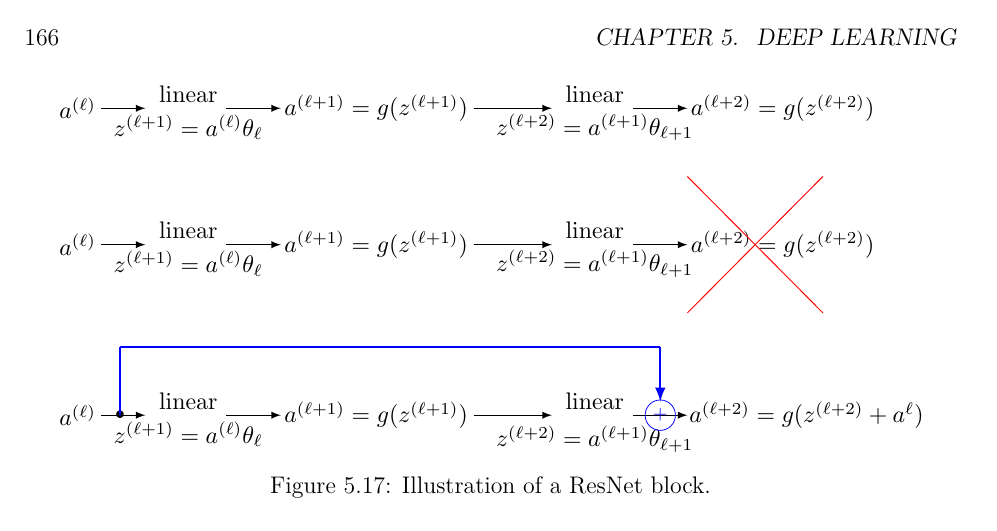

El siguiente dibujo es del artículo original

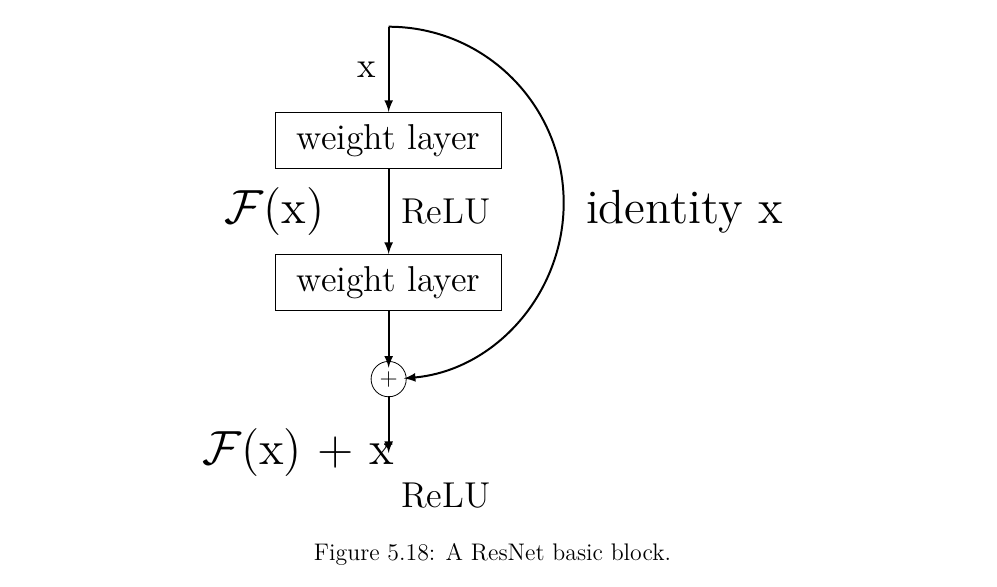

Por que esto podria ser ventajoso?

Recuerde que el problema de todas las redes hasta este punto es el "vanishing gradient".

Observamos que el gradiente **con respecto a $x$** de la función

* **sin sumar el residual**
$$ \nabla \mathcal{F}(x) \approx 0 $$
asumiendo que estamos en la parte lejanda donde actúa el "vanishing gradient"
* **sumándole el residual** es:
$$\nabla_x ( \mathcal{F}(x) + x) = \nabla_x \mathcal{F}(x) + I  $$
Lejos de 0.

La idea de He et al. es que $I$ es una constante que me estabiliza el gradiente y me evita el problema del vanishing gradient.


In [ ]:
# implementacion del ResNet
from tensorflow.keras.layers import Conv2D, Add, Activation

def resitual_module(x, n_filters):
    conv1 = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    conv1 = Activation('relu')(conv1)

    conv2 = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal')(conv1)
    conv2 = Activation('relu')(conv2)

    add = Add()([conv2, x])

    # activation ReLU
    return Activation('relu')(add)